# 1. Importing Dependencies

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# 2. Loading and Exploring Data

In [2]:
# Loading data
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

> Let's take a quick look at the data to determine the data types for each feature.

In [3]:
# Quick look at train data
train_df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
645,646,1,1,"Harper, Mr. Henry Sleeper",male,48.00,1,0,PC 17572,76.7292,D33,C
469,470,1,3,"Baclini, Miss. Helene Barbara",female,0.75,2,1,2666,19.2583,NaN,C
801,802,1,2,"Collyer, Mrs. Harvey (Charlotte Annie Tate)",female,31.00,1,1,C.A. 31921,26.2500,NaN,S
99,100,0,2,"Kantor, Mr. Sinai",male,34.00,1,0,244367,26.0000,NaN,S
550,551,1,1,"Thayer, Mr. John Borland Jr",male,17.00,0,2,17421,110.8833,C70,C


In [4]:
# Quick look at test data
test_df.sample(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
261,1153,3,"Nilsson, Mr. August Ferdinand",male,21.0,0,0,350410,7.8542,NaN,S
88,980,3,"O'Donoghue, Ms. Bridget",female,NaN,0,0,364856,7.7500,NaN,Q
403,1295,1,"Carrau, Mr. Jose Pedro",male,17.0,0,0,113059,47.1000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
366,1258,3,"Caram, Mr. Joseph",male,NaN,1,0,2689,14.4583,NaN,C


In [5]:
# Determining data types
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Based on the codes above, we can determine the data types of the features in our data:
* Numerical: Age, SibSp, Parch, Fare
* Categorical: **Survived (TARGET)**, Pclass, Sex, Embarked
* Alphanumerical: Ticket, Cabin


In [6]:
# Descriptive statistics about train data
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [7]:
# Determining amount of NA values
pd.isnull(train_df).sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

From the code above, we can see that:
* Age is missing 177 out of 891 observations.
* Cabin is missing 687 out of 891 observations.
* Embarked is missing 2 out of 891 observations.

# 3. Data Preprocessing

> We will start by looking at the NA values in the columns listed above. For ['Age'], a variable that is often skewed, we will be replacing the NA values with the median.

In [8]:
# Filling NA values in Age
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].median())

> Moving on to ['Embarked']. Since it is a categorical variable, we will be filling the NA values with the mode.

In [9]:
# Filling NA values in Embarked
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])

0      S
1      C
2      S
3      S
4      S
      ..
886    S
887    S
888    S
889    C
890    Q
Name: Embarked, Length: 891, dtype: object

In [10]:
# Treating NA values in Cabin
# We will do this by creating a binary feature
train_df['HasCabin'] = train_df['Cabin'].notnull().astype(int)

In [11]:
# Converting categorical variables (Sex + Embarked)
le = LabelEncoder()
train_df['Sex'] = le.fit_transform(train_df['Sex'])
train_df['Embarked'] = le.fit_transform(train_df['Embarked'])

In [12]:
# Converting categorical variables (Pclass) using Ordinal Encoding
pclass_map = {1: 1, 2: 2, 3: 3}
train_df['Pclass'] = train_df['Pclass'].map(pclass_map)

> For ['Names'], we can probably use it as feature by extracting the titles and seeing if they impacted whether someone survived or not.

In [13]:
# Dropping unnecessary columns
train_df = train_df.drop(['Name', 'Ticket', 'Cabin'], axis=1)

In [14]:
# Doing the same for our test data
test_df['Age'] = test_df['Age'].fillna(test_df['Age'].median())
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].median())

test_df['Sex'] = le.fit_transform(test_df['Sex'])
test_df['Embarked'] = le.fit_transform(test_df['Embarked'])

test_df['HasCabin'] = test_df['Cabin'].notnull().astype(int)

test_df = test_df.drop(['Name', 'Ticket', 'Cabin'], axis=1)

# 4. Feature Engineering

In [15]:
# Creating a 'GroupSize' feature
train_df['GroupSize'] = train_df['SibSp'] + train_df['Parch'] + 1

In [16]:
# Creating a 'IsAlone' feature
train_df['IsAlone'] = 1
train_df.loc[train_df['GroupSize'] > 1, 'IsAlone'] = 0

In [17]:
# Doing the same for our test data
test_df['GroupSize'] = test_df['SibSp'] + test_df['Parch'] + 1

test_df['IsAlone'] = 1
test_df.loc[test_df['GroupSize'] > 1, 'IsAlone'] = 0

# 5. Splitting Data

In [18]:
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# 6. Modeling

In [19]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

In [20]:
# Accuracy score
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 80.60%


Text(0.5, 1.0, 'Confusion Matrix')

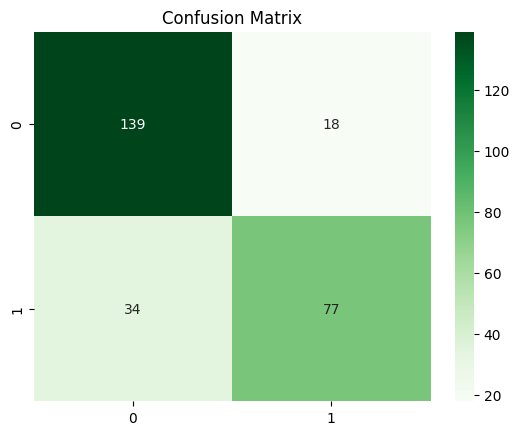

In [21]:
# Generating a confusion matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix')

In [22]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)

        Feature  Importance
2           Sex    0.233187
6          Fare    0.184066
0   PassengerId    0.179140
3           Age    0.160591
1        Pclass    0.064973
9     GroupSize    0.044057
8      HasCabin    0.042313
7      Embarked    0.034378
4         SibSp    0.025092
5         Parch    0.021151
10      IsAlone    0.011052


# 7. Creating a Submission File

In [23]:
X_test = test_df
test_predictions = model.predict(X_test)

submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': test_predictions
})

submission.to_csv('submission.csv', index=False)